# Goal
* Generate many functions. 
    * Model the function with an MLP and fit with n epochs
    * Use the MLP to find $dydx$ and $d2y/d2x$ using `torch.autograd.grad`.
    * Use the  range of -1 to 1
    * Calculate the expected $dydx$ and $d2y/d2x$ for each function using sympy
    * Compare the L2 error between the analytical values and the MLP evaluted values for $dydx$ and $d2y/d2x$ 
    * Record the error values 
    * Plot the performance of the MLP to model the function and its deriviates


In [455]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from  sympy import *
import random
import numpy as np
import warnings
from base import *
from dataclasses import dataclass
from dataclasses_json import dataclass_json
from pathlib import Path

In [419]:
%matplotlib inline

In [420]:
do_step = Stepper()

# Randomly generate an equation

In [421]:
x = symbols("x")

In [422]:
def add(x1,x2): return x1-x2
def minus(x1, x2): return x1-x2
def power(x1, x2): return x1**x2
def identity(x1): return x1
# def sin_with_frequency(x1, x2): return sin(x1*x2)

Here we are making a list of operations we might use. We break it up into two types of operations
* operations with just a single input
* operations with a input and a second number

In [423]:
fns = [cos, sin, identity]
fns2 = [add, minus, power]

Make an expression will combine together `number_of_num_fncs` of operations together. For each operation it will first randomly pick an operation in the list `fns` or `fns2` with the only difference being that for `fns2` operations, it will need to generate another random value as an additional argument to the operation.  

In [424]:
def make_equation(number_of_num_fncs):
    y  = 1
    for i in range(number_of_num_fncs):
        if random.randint(0,1)==0:
            # only requires 1 input. 
            fn = random.choice(fns)
            y = y*fn(x)
        else:
            # requires 2 inputs. 
            fn = random.choice(fns2)
            value = random.random()-0.5
            # now choose if x is the input
            if type(y)!=int and  y.has(x): # first, make sure y already has an x in its expression
                if random.randint(0,1)==0:
                    y = y*fn(x,value) # just use x as the input
                else:
                    print(f"making composite, fn is {str(fn)} and  y = {y}")
                    y = fn(y,value) # do a composite function
                    
            else:
                # if missing x in the express, then we need to use X for sure as the 1st input. 
                y = y*fn(x,value)
#         print(i, y)

    # catch the special case where everything cancels out. Just make the identity function
    if type(y)==int or  y.has(x)== False:
        print(f"catching function with nothing {y}")
        y = x
    return y
    

We call `make_equation` twice for the numerator and operator, then combine the results to make a whole equation. 

In [425]:
def make_whole_equation(possible_operations = 3, min_operations = 1):
    number_of_num_fncs_numerator = random.randint(min_operations,possible_operations)
    number_of_num_fncs_denominator = random.randint(min_operations,possible_operations)
#     print(number_of_num_fncs_numerator,number_of_num_fncs_denominator )
    numerator = make_equation(number_of_num_fncs_numerator)
    denominator = make_equation(number_of_num_fncs_numerator)
    equation = numerator/denominator
    if type(equation)==int or  equation.has(x)== False:
        print(f"catching function with nothing {equation} within make_whole_equation")
        equation = x
    return equation

In [426]:
equation = make_whole_equation()
equation

making composite, fn is <function add at 0x000001C3ACEC4EE0> and  y = x**1.42488621167199
making composite, fn is <function minus at 0x000001C3ACEC4B80> and  y = (x + 0.387811371643577)*(x + 0.475682368513832)


(x**1.42488621167199 - 0.0625852585048804)/((x + 0.387811371643577)*(x + 0.475682368513832) - 0.2415706263371)

In [427]:
equation

(x**1.42488621167199 - 0.0625852585048804)/((x + 0.387811371643577)*(x + 0.475682368513832) - 0.2415706263371)

We take the symbolic equation and convert it to a numpy function using `lambdify`. Then we evalute the function at the points in `x_numeric` and then plot to see if everything is working. 

In [428]:
f = lambdify(x, equation, "numpy")

In [429]:
x_numeric = np.linspace(-1,1, 40)

In [430]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    y = f(x_numeric)
    y = np.nan_to_num(y)

Text(0.5, 1.0, 'function')

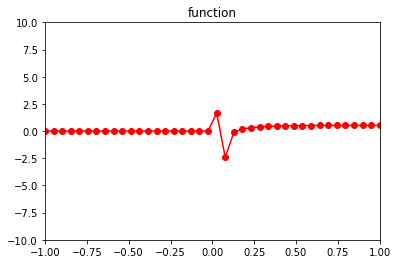

In [431]:
plt.plot(x_numeric, y, 'ro-')
plt.ylim([-10,10])
plt.xlim([-1,1])
plt.title("function")

Next, we calculate the analytical first derivative. Then we turn the function into a numpy function, evalute, and plot. 

In [432]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
#     dydx = simplify( diff(equation, x))
    dydx =  diff(equation, x)

In [433]:
dydx

1.42488621167199*x**0.424886211671994/((x + 0.387811371643577)*(x + 0.475682368513832) - 0.2415706263371) + (-2*x - 0.86349374015741)*(x**1.42488621167199 - 0.0625852585048804)/((x + 0.387811371643577)*(x + 0.475682368513832) - 0.2415706263371)**2

In [434]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    f_dydx = lambdify(x, dydx, "numpy")
    dydx_values = f_dydx(x_numeric)
    dydx_values = np.nan_to_num(dydx_values)

Text(0.5, 1.0, 'dydx')

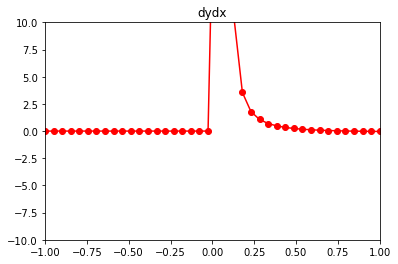

In [435]:
plt.plot(x_numeric, dydx_values, 'ro-')
plt.ylim([-10,10])
plt.xlim([-1,1])
plt.title("dydx")

We do the same thing for hte 2nd derivative. 

In [436]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    d2yd2x =  diff(dydx, x)
    f_d2yd2x = lambdify(x, d2yd2x, "numpy")
    d2yd2x_values = f_d2yd2x(x_numeric)
    d2yd2x_values = np.nan_to_num(d2yd2x_values)

Text(0.5, 1.0, 'd2yd2x')

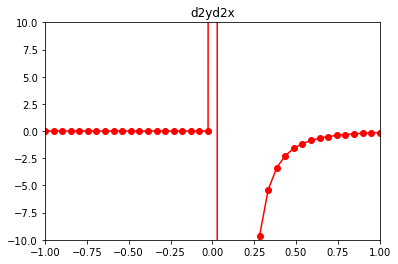

In [437]:
plt.plot(x_numeric, d2yd2x_values, 'ro-')
plt.ylim([-10,10])
plt.xlim([-1,1])
plt.title("d2yd2x")

## MLP
* make an mlp
* fit it to y values 
* measure the error for y, dydx, and d2yd2x

Notes:
* convert nan's to 0 and infinity to a large number with `nan_to_num`
* convert to tensor
* convert to batch format
* convert to float32

In [438]:
# clip eerything to be in the range of -nn to nn
nn = 30

# make a torch version of the symbolically found dydx
dydx_values_true_t = torch.Tensor(dydx_values)
d2yd2x_values_true_t  = torch.Tensor(d2yd2x_values)
y = torch.Tensor(y)
my_tensors  = [ dydx_values_true_t,d2yd2x_values_true_t, y]
dydx_values_true_t,d2yd2x_values_true_t, y = [torch.clamp(v,-nn,nn) for v in my_tensors]

In [439]:
# x_numeric_t, y_t = [torch.tensor(z) for z in  [x_numeric,y]]
xb, yb = [make_batch(torch.tensor(np.nan_to_num(z))).to(torch.float32) for z in [x_numeric,y]]
yb_normalizer = Normalizer(yb)
yb_norm = yb_normalizer.norm(yb)

## Train the MLP
* a learning rate higher than 1e-2 is generally unstable. 

In [440]:
mlp = make_mlp(n = 100, layers_count=3, act = Mish)

In [454]:
xb.shape

torch.Size([40, 1])

In [441]:
do_step2 = Stepper_v2(mlp, xb, yb_norm)

In [442]:
do_step2.do_epochs(int(1e4), lr = 1e-4)

Text(0.5, 1.0, 'loss per epoch')

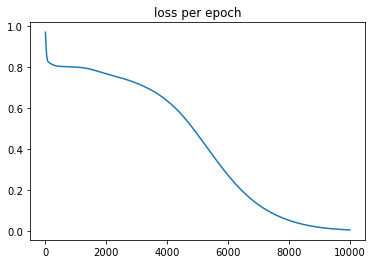

In [443]:
plt.plot(do_step2.loss_list)
plt.title("loss per epoch")

Text(0.5, 1.0, 'function')

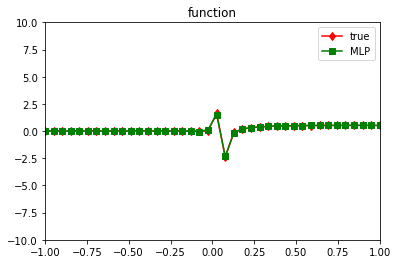

In [444]:
yprime = mlp(xb)

yprime_debatch = yb_normalizer.denorm(   debatch(yprime))
# x_debatch = debatch(x)

plt.plot(x_numeric,y, "rd-", label = "true")
plt.plot(x_numeric,yprime_debatch, "gs-", label = "MLP")
plt.legend()
plt.ylim([-10,10])
plt.xlim([-1,1])
plt.title("function")

## calculate dydx and compare to dydx found symbolically

In [445]:
xb.requires_grad = True
yprime_pre = mlp(xb)
yprime_pre.retain_grad()
# yprime_pre.requires_grad = True
yprime = yb_normalizer.denorm(   yprime_pre)

dydx = torch.autograd.grad(yprime.sum(), xb, create_graph=True)[0]

d2yd2x = torch.autograd.grad(dydx.sum(), xb, create_graph=True)[0]

dydx, d2yd2x = [debatch(v) for v in [dydx, d2yd2x ]]

my_tensors  = [dydx, d2yd2x]
dydx, d2yd2x= [torch.clamp(v,-nn,nn) for v in my_tensors]

Text(0.5, 1.0, 'dydx')

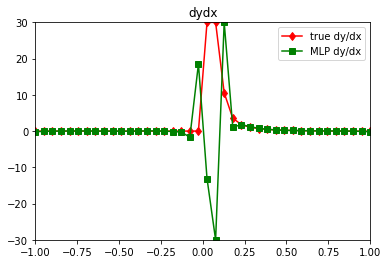

In [446]:
plt.plot(x_numeric,dydx_values_true_t, "rd-", label = "true dy/dx")
plt.plot(x_numeric,dydx, "gs-", label = "MLP dy/dx")
plt.legend()

# plt.plot(x_numeric, dydx_values, 'ro-')
plt.ylim([-nn,nn])
plt.xlim([-1,1])
plt.title("dydx")

In [447]:

dydx_error = F.mse_loss(dydx_values_true_t,debatch(dydx))
dydx_error

tensor(154.6720)

In [448]:
dydx_values.shape, d2yd2x_values_true_t.shape

((40,), torch.Size([40]))

Text(0.5, 1.0, 'd2yd2x')

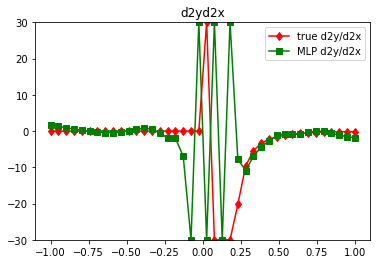

In [449]:
plt.plot(x_numeric,d2yd2x_values_true_t, "rd-", label = "true d2y/d2x")
plt.plot(x_numeric,debatch(d2yd2x), "gs-", label = "MLP d2y/d2x")
plt.legend()
plt.ylim([-nn,nn])
plt.title("d2yd2x")

In [450]:
d2yd2x_error = F.mse_loss(d2yd2x_values_true_t, d2yd2x)
d2yd2x_error

tensor(320.7491)

dydx_error = F.mse_loss(dydx_values_true_t,debatch(dydx))
dydx_error# Put it all together now in a loop
* 

In [461]:
@dataclass_json
@dataclass
class Results:
    fn_loss:float
    dydx_loss:float
    d2yd2x_loss:float
    fn:str

In [464]:
r = Results(do_step2.loss_list[-1].item(), dydx_error.item(), d2yd2x_error.item(), str(equation))
r

Results(fn_loss=0.00507177272811532, dydx_loss=154.6720428466797, d2yd2x_loss=320.7490539550781, fn='(x**1.42488621167199 - 0.0625852585048804)/((x + 0.387811371643577)*(x + 0.475682368513832) - 0.2415706263371)')

In [492]:
def make_file_name(idx, p):
    return p / f"result_{idx}.json"

def parse_file_name(fname):
    i = fname.stem.find("_")
    return int(fname.stem[i+1:])

def get_next_idx(folder):
    files = list(folder.rglob("*.json"))
    idxs = [parse_file_name(f) for f in files]
    new_idx = max(idxs)+1
    return new_idx

p = Path("results")
p.mkdir(exist_ok=True)

In [495]:
new_idx = get_next_idx(p)
new_idx

1

In [480]:
j = r.to_json()
fname = make_file_name(new_idx,p)
with open(fname, 'w') as f:
    f.write(j)
    

In [481]:
fname.absolute()

WindowsPath('C:/Users/garla/git/torch_tutorials_to_shared/scratch/9_working_toward_evaluting_with_sympy/results/result_0.json')

0

In [474]:
# print(dataconf.string(r, Results))
# # Example(hello

In [451]:
# # yprime_debatch

# # yprime





# for i in range(300):
#     yprime_out = do_step(mlp, xb, yb, lr = 1e-1)

# plt.plot(x,y, "rd-", label = "true")
# plt.plot(x,yprime_out, "gs-", label = "MLP")
# plt.legend()

# xb.requires_grad = True
# yprime = mlp(xb)

# dydx = torch.autograd.grad(yprime.sum(), xb, create_graph=True)[0]

# d2yd2x = torch.autograd.grad(dydx.sum(), xb, create_graph=True)[0]

# # y, dydx_analytical, d2yd2x_analytical 



In [452]:
# plt.plot(x,dydx_analytical, "rd-", label = "true dy/dx")
# plt.plot(x,debatch(dydx), "gs-", label = "MLP dy/dx")
# plt.legend()

In [453]:
# plt.plot(x,d2yd2x_analytical, "rd-", label = "true d2y/d2x")
# plt.plot(x,debatch(d2yd2x), "gs-", label = "MLP d2y/d2x")
# plt.legend()